In [5]:
import os
os.chdir('/Users/gintas/Documents/SchoolProjects/balsas_lab2/balsas-lab2')

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from prototype_learning.OnePerClassPrototypeModel import OnePerClassPrototypeModel
from preprocessing.AudioPreprocessingLayer import AudioPreprocessingLayer
from preprocessing.AudioDataset import AudioDataset
from torch.utils.data import DataLoader
import os

labels = ["up", "down", "left", "right", "go", "no", "stop", "yes"]

# Evaluation function
def evaluate_model(dataloader, model, device):
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for batch_x, labels in dataloader:
            batch_x, labels = batch_x.to(device), labels.to(device)
            model_out = model(batch_x)
            _, pred_y = model_out
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(pred_y.cpu().numpy())

    # Metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')  # Sensitivity
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    tn = conf_matrix[0, 0]
    fp = conf_matrix[0, 1]
    fn = conf_matrix[1, 0]
    tp = conf_matrix[1, 1]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return accuracy, precision, recall, specificity, conf_matrix

# Load model
device = 'cpu'
model = OnePerClassPrototypeModel(num_classes=len(labels)).to(device)
model.load_state_dict(torch.load("model.pt"))
model.eval()

# Load datasets and create dataloaders
audio_preprocess = AudioPreprocessingLayer(
    input_freq=16000, resample_freq=16000, n_mfcc=13, max_duration_ms=1000, augment=False
)
# Load TRAINING dataset
dataset_train = AudioDataset(dataset_path="dataset_train.txt", included_classes=labels, enable_transform_cache=True, cache_in_memory=False, transform=audio_preprocess)
dataloader_train = DataLoader(dataset_train, batch_size=1000, shuffle=False, num_workers=os.cpu_count())

# Load VALIDATION dataset
dataset_validate = AudioDataset(dataset_path="dataset_validate.txt", included_classes=labels, enable_transform_cache=True, cache_in_memory=False, transform=audio_preprocess)
dataloader_validate = DataLoader(dataset_validate, batch_size=1000, shuffle=False, num_workers=os.cpu_count())
dataset_validate.global_min = dataset_train.global_min
dataset_validate.global_max = dataset_train.global_max
dataset_validate.global_mean = dataset_train.global_mean
dataset_validate.global_std = dataset_train.global_std

# Load TESTING dataset
dataset_test = AudioDataset(dataset_path="dataset_test.txt", included_classes=labels, enable_transform_cache=True, cache_in_memory=False, transform=audio_preprocess)
dataloader_test = DataLoader(dataset_test, batch_size=1000, shuffle=False, num_workers=os.cpu_count())
dataset_test.global_min = dataset_train.global_min
dataset_test.global_max = dataset_train.global_max
dataset_test.global_mean = dataset_train.global_mean
dataset_test.global_std = dataset_train.global_std

# metrics_validate = evaluate_model(dataloader_validate, model, device)
# metrics_test = evaluate_model(dataloader_test, model, device)


/Users/gintas/Documents/SchoolProjects/balsas_lab2/balsas-lab2/.venv/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


/Users/gintas/Documents/SchoolProjects/balsas_lab2/balsas-lab2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Dataset:
Accuracy: 0.1287630402384501, Precision: 0.22434079601990048, Recall (Sensitivity): 0.12590969408096353, Specificity: 1.0

[[429   0   0   0   0   0   0   0]
 [430   0   0   0   0   0   0   0]
 [407   0   0   0   0   0   0   0]
 [419   0   0   0   0   0   0   0]
 [415   0   0   0   2   0   0   0]
 [425   0   0   0   0   0   0   0]
 [401   0   0   0   1   0   1   0]
 [424   0   1   0   0   0   0   0]]


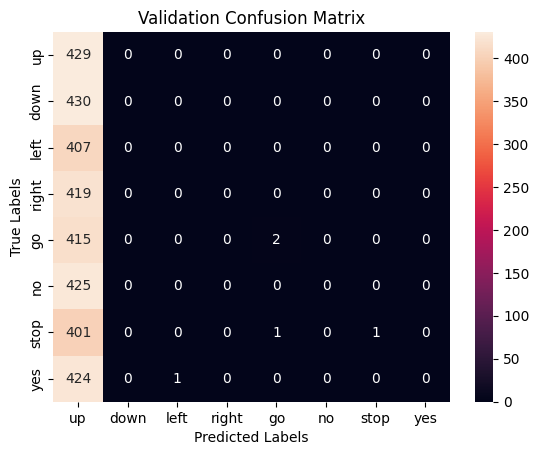

In [6]:
metrics = evaluate_model(dataloader_validate, model, device)
name = "Validation"
accuracy, precision, recall, specificity, conf_matrix = metrics
print(f"{name} Dataset:")
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall (Sensitivity): {recall}, Specificity: {specificity}\n")
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title(f"{name} Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()